In [1]:
!pip install transformers
import re
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from transformers import pipeline, set_seed
from transformers import RobertaTokenizer, RobertaModel
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import AutoModel, BertTokenizerFast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 7.9 MB/s 
     |████████████████████████████████| 6.6 MB 47.5 MB/s 
     |████████████████████████████████| 101 kB 12.9 MB/s 
     |████████████████████████████████| 596 kB 67.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
def load_data(path):
    #return pd.read_csv(path, sep='\t', header=None)
    with open(path, 'r', encoding='utf8') as f:
        return f.readlines()

In [3]:
def write_res(data, path):
    with open(path, 'w') as f:
        for line in data:
            f.write(f'{line}\n')
    print(f"Data written {path}/out.tsv")

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
import pandas as pd
train_input = pd.read_csv("/content/drive/MyDrive/paranormal-or-skeptic/train/in.tsv", sep = '\t', names = ['text', 'label'], header=None, nrows=10000)
# train['text'] = train['text'].apply(lambda x: tokenizer(x, return_tensors='pt'))
train_input['label'] = pd.read_csv("/content/drive/MyDrive/paranormal-or-skeptic/train/expected.tsv", header=None, nrows=10000)
train_input

text  label
0              have you had an medical issues recently?      1
1     It's supposedly aluminum, barium, and strontiu...      0
2                     Nobel prizes don't make you rich.      0
3      I came for the article, I stayed for the doctor.      0
4     you resorted to insults AND got owned directly...      0
...                                                 ...    ...
9995  &gt;a very very very very very liberal college...      0
9996  To be fair, most of Newton's writings were on ...      0
9997                  your elementary idea is brilliant      0
9998                 I know! I was like ...Simon Pegg??      1
9999  You seem to have missed the purpose of my post...      0

[10000 rows x 2 columns]

In [6]:
dev = pd.read_csv("/content/drive/MyDrive/paranormal-or-skeptic/dev-0/in.tsv", sep = '\t', names = ['text', 'label'], header=None)
# test['text'] = test['text'].apply(lambda x: tokenizer(x, return_tensors='pt'))
dev['label'] = pd.read_csv("/content/drive/MyDrive/paranormal-or-skeptic/dev-0/expected.tsv", header=None)
dev

text  label
0     In which case, tell them I'm in work, or dead,...      0
1     Put me down as another for Mysterious Universe...      1
2     The military of any country would never admit ...      1
3     An example would have been more productive tha...      0
4     sorry, but the authors of this article admit t...      0
...                                                 ...    ...
5267  Your fault for going at all. That's how we get...      0
5268      EVP....that's a shot in the GH drinking game.      1
5269  i think a good hard massage is good for you. t...      0
5270  Interesting theory. Makes my imagination run w...      1
5271  Tampering of candy? More like cooking somethin...      0

[5272 rows x 2 columns]

In [7]:
test = pd.read_csv("/content/drive/MyDrive/paranormal-or-skeptic/test-A/in.tsv", sep = '\t', names = ['text', 'label'], header=None)
# test['text'] = test['text'].apply(lambda x: tokenizer(x, return_tensors='pt'))
# test['label'] = pd.read_csv("/content/drive/MyDrive/paranormal-or-skeptic/test-A/expected.tsv", header=None)
test = test.drop(['label'], axis=1)
test

text
0     Gentleman, I believe we can agree that this is...
1     The problem is that it will just turn it r/nos...
2     Well, according to some Christian apologists, ...
3     Don't know if this is what you are looking for...
4     I respect what you're saying completely. I jus...
...                                                 ...
5147                                             GAMBIT
5148  &gt;Joe Rogan is no snake oil salesman.\n\nHe ...
5149  Reading further, Sagan does seem to agree with...
5150  Notice that they never invoke god, or any othe...
5151  They might co-ordinate an anniversary attack o...

[5152 rows x 1 columns]

In [8]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

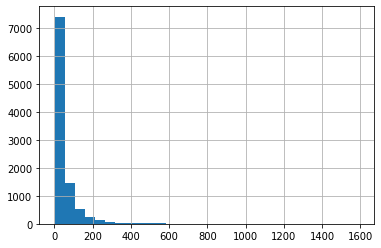

In [9]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_input['text']]

pd.Series(seq_len).hist(bins = 30)

In [10]:
max_seq_len = 100

In [11]:
# tokenize and encode sequences in the sets
tokens_train = tokenizer.batch_encode_plus(
    train_input['text'].tolist(), 
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

tokens_dev = tokenizer.batch_encode_plus(
    dev['text'].tolist(), 
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

tokens_test = tokenizer.batch_encode_plus(
    test['text'].tolist(), 
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [12]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_input['label'].tolist())

# for validation set
val_seq = torch.tensor(tokens_dev['input_ids'])
val_mask = torch.tensor(tokens_dev['attention_mask'])
val_y = torch.tensor(dev['label'].tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor([])

In [13]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 16

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)


In [14]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [15]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [16]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [17]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [18]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', classes = np.unique(train_input['label']), y = train_input['label'])

print(class_wts)

[0.7732756  1.41482739]


In [19]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 3

In [20]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [21]:
import time
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      #elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [22]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights_10k.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 3
  Batch    50  of    625.
  Batch   100  of    625.
  Batch   150  of    625.
  Batch   200  of    625.
  Batch   250  of    625.
  Batch   300  of    625.
  Batch   350  of    625.
  Batch   400  of    625.
  Batch   450  of    625.
  Batch   500  of    625.
  Batch   550  of    625.
  Batch   600  of    625.

Evaluating...
  Batch    50  of    330.
  Batch   100  of    330.
  Batch   150  of    330.
  Batch   200  of    330.
  Batch   250  of    330.
  Batch   300  of    330.

Training Loss: 0.663
Validation Loss: 0.617

 Epoch 2 / 3
  Batch    50  of    625.
  Batch   100  of    625.
  Batch   150  of    625.
  Batch   200  of    625.
  Batch   250  of    625.
  Batch   300  of    625.
  Batch   350  of    625.
  Batch   400  of    625.
  Batch   450  of    625.
  Batch   500  of    625.
  Batch   550  of    625.
  Batch   600  of    625.

Evaluating...
  Batch    50  of    330.
  Batch   100  of    330.
  Batch   150  of    330.
  Batch   200  of    330.
  Batch   250

In [48]:
#load weights of best model
path = './saved_weights_10k.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [34]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq[:1000].to(device), test_mask[:1000].to(device))
  preds = preds.detach().cpu().numpy()

In [43]:
def predict(model, seq, mask):
    result = []
    
    with torch.no_grad():
        for i in range(0, len(seq), 16):
            s = seq[i:i+16]
            m = mask[i:i+16]
            preds = model(s[i].to(device), m[i].to(device))
            preds = preds.detach().cpu().numpy()
            preds = np.argmax(preds, axis = 1)
            result.extend(preds)

    return result

In [48]:
result = []
for i in range(int(len(test_seq)/5)):
  x0 = i*int(len(test_seq)/5)
  x1 = (i+1)*int(len(test_seq)/5)
  preds = model(test_seq[x0:x1].to(device), test_mask[x0:x1].to(device))
  preds = preds.detach().cpu().numpy()
  preds = np.argmax(preds, axis = 1)
  result.extend(preds)
result

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [53]:
write_res(result, './test_out.tsv')

Data written ./test_out.tsv/out.tsv


In [55]:
result_dev = []
for i in range(int(len(val_seq)/5)):
  x0 = i*int(len(val_seq)/5)
  x1 = (i+1)*int(len(val_seq)/5)
  preds = model(val_seq[x0:x1].to(device), val_mask[x0:x1].to(device))
  preds = preds.detach().cpu().numpy()
  preds = np.argmax(preds, axis = 1)
  result_dev.extend(preds)
write_res(result_dev, './dev_out.tsv')
len(result_dev)

Data written ./dev_out.tsv/out.tsv


5272